In [1]:
import cv2
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
from nvidia.dali.plugin.pytorch import LastBatchPolicy
from nvidia.dali.plugin.pytorch import DALIGenericIterator
import nvidia.dali.types as types
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Optional, Union, Literal, Tuple

# see https://pytorch.org/vision/stable/models.html
_IMAGENET_MEAN = [0.485, 0.456, 0.406]
_IMAGENET_STD = [0.229, 0.224, 0.225]

In [21]:
@pipeline_def
def video_pipe(
    filenames: Union[List[str], str],
    resize_dims: Optional[List[int]] = None,
    random_shuffle: bool = False,
    seed: int = 123456,
    sequence_length: int = 16,
    pad_sequences: bool = True,
    initial_fill: int = 16,
    normalization_mean: List[float] = _IMAGENET_MEAN,
    normalization_std: List[float] = _IMAGENET_STD,
    device: str = "gpu",
    name: str = "reader",
    step: int = 1,
    pad_last_batch: bool = False,
    # arguments consumed by decorator:
    # batch_size,
    # num_threads,
    # device_id
) -> tuple:
    """Generic video reader pipeline that loads videos, resizes, augments, and normalizes.

    Args:
        filenames: list of absolute paths of video files to feed through
            pipeline
        resize_dims: [height, width] to resize raw frames
        random_shuffle: True to grab random batches of frames from videos;
            False to sequential read
        seed: random seed when `random_shuffle` is True
        sequence_length: number of frames to load per sequence
        pad_sequences: allows creation of incomplete sequences if there is an
            insufficient number of frames at the very end of the video
        initial_fill: size of the buffer that is used for random shuffling
        normalization_mean: mean values in (0, 1) to subtract from each channel
        normalization_std: standard deviation values to subtract from each
            channel
        device: "cpu" | "gpu"
        name: pipeline name, used to string together DataNode elements
        step: number of frames to advance on each read
        pad_last_batch

    Returns:
        pipeline object to be fed to DALIGenericIterator

    """
    video = fn.readers.video(
        device=device,
        filenames=filenames,
        random_shuffle=random_shuffle,
        seed=seed,
        sequence_length=sequence_length,
        step=step,
        pad_sequences=pad_sequences,
        initial_fill=initial_fill,
        normalized=False,
        name=name,
        dtype=types.DALIDataType.FLOAT,
        pad_last_batch=pad_last_batch,  # Important for context loaders
        file_list_include_preceding_frame=True,  # to get rid of dali warnings
    )
    if resize_dims:
        video = fn.resize(video, size=resize_dims)
    # video pixel range is [0, 255]; transform it to [0, 1].
    # happens naturally in the torchvision transform to tensor.
    video = video / 255.0
    # permute dimensions and normalize to imagenet statistics
    transform = fn.crop_mirror_normalize(
        video,
        output_layout="FCHW",
        mean=normalization_mean,
        std=normalization_std,
    )
    return transform


def count_frames(video_list: Union[List[str], str]) -> int:
    """Simple function to count the number of frames in a video or a list of videos."""
    if isinstance(video_list, str):
        video_list = [video_list]
    num_frames = 0
    for video_file in video_list:
        cap = cv2.VideoCapture(video_file)
        num_frames += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

    return num_frames


class LitDaliWrapper(DALIGenericIterator):
    """wrapper around a DALI pipeline to get batches for ptl."""

    def __init__(
        self,
        *args,
        num_iters: int = 1,
        **kwargs
    ) -> None:
        """Wrapper around DALIGenericIterator to get batches for pl.

        Args:
            num_iters: number of enumerations of dataloader (should be computed outside for now;
                should be fixed by lightning/dali teams)

        """
        self.num_iters = num_iters
        self.batch_sampler = 1  # hack to get around DALI-ptl issue
        # call parent
        super().__init__(*args, **kwargs)

    def __len__(self) -> int:
        return self.num_iters

    def __next__(self):
        return super().__next__()

provide a path to some video file for testing -- here is one test video from this repo.

In [3]:
!ls /home/jovyan

conda	    figs	    litpose-data  test_vid_with_fr.mp4
datastores  lightning-pose  test.npy	  work


In [3]:
video_file = "../toy_datasets/toymouseRunningData/unlabeled_videos/test_vid.mp4"

## Temporal Context loader
Here are we define a pipeline that reads sequences of 5 frames at a time.
In practice we have a model that takes 5 frames as input and outputs a pose for the 3rd frame, but we omit the model now.

In [4]:

# args for context loader
pipe_args = {
    "filenames": video_file,
    "resize_dims": [64, 64],
    "sequence_length": 5,
    "step": 1,
    "batch_size": 16,
    "num_threads": 4,
    "device_id": 0,
    "random_shuffle": False,
    "device": "gpu",
    "name": "reader",
    "pad_sequences": True,
    "pad_last_batch": True,
}

pipe = video_pipe(**pipe_args)

# set up parameters for pytorch iterator
frame_count = count_frames(video_file)
# taken from https://github.com/danbider/lightning-pose/blob/b66fe34719ec89631f74c6c911a5e1a013bc7e34/lightning_pose/data/dali.py#L237

# this is for the base prediction, no context
# num_iters = int(np.ceil(frame_count / pipe_args["sequence_length"]))

# context loader, different way of calculating num_iters
num_iters = int(np.ceil(frame_count / (pipe_args["batch_size"])))

iterator_args = {
    "num_iters": num_iters,
    "output_map": ["frames"],
    "last_batch_policy": LastBatchPolicy.FILL,
    "auto_reset": False,
    "reader_name": "reader"
}


In [5]:
num_iters

63

In [6]:
# build iterator
iterator = LitDaliWrapper(pipe, **iterator_args)


In [7]:
# iterate over data
from time import time
start_time = time()
for batch in tqdm(iterator):
    shape =batch[0]["frames"].shape # we don't print now to avoid cluttering the notebook
end_time = time()
print(f"Time to iterate over {num_iters} batches: {end_time - start_time}")

100%|██████████| 63/63 [00:30<00:00,  2.06it/s]

Time to iterate over 63 batches: 30.634568452835083


In [8]:
total_time = end_time - start_time
time_per_iter = total_time / num_iters

In [9]:
time_per_iter

0.4862629913148426

## Base prediction
Now define the args for base prediction. Just iterate over sequences until we reach the end of the video. In practice we have a standard resnet waiting for these frames and evaluated in the standard way.

In [34]:
# video_file = "/home/jovyan/datastores/mirror-mouse/videos_new/180607_004.mp4"

# frame_count = count_frames(video_file)


In [35]:
# args for base predict loader
pipe_args = {
    "filenames": video_file,
    "resize_dims": [64, 64],
    "sequence_length": 64,
    "step": 64,
    "batch_size": 1,
    "num_threads": 4, # was 4
    "device_id": 0,
    "random_shuffle": False,
    "device": "gpu", 
    "name": "reader",
    "pad_sequences": True,
}

num_iters = int(np.ceil(frame_count / pipe_args["sequence_length"]))

# https://github.com/danbider/lightning-pose/blob/0d9c26c42cbddbd16a8f01937d714d221474225d/lightning_pose/data/dali.py#L386
iterator_args = {
    "num_iters": num_iters,
    "output_map": ["frames"],
    "last_batch_policy": LastBatchPolicy.FILL,
    "last_batch_padded": False,
    "auto_reset": False,
    "reader_name": "reader"
}

In [36]:
num_iters

469

In [37]:
pipe = video_pipe(**pipe_args)

In [38]:
# build iterator
iterator = LitDaliWrapper(pipe, **iterator_args)


In [39]:
# iterate over data
from time import time
start_time = time()
for batch in tqdm(iterator):
    shape =batch[0]["frames"].shape # we don't print now to avoid cluttering the notebook
end_time = time()
print(f"Time to iterate over {num_iters} batches: {end_time - start_time}")

100%|██████████| 469/469 [00:23<00:00, 19.94it/s]

Time to iterate over 469 batches: 23.523786544799805


In [46]:
total_time = end_time - start_time
time_per_iter = total_time / num_iters
print(f"Time per iteration: {time_per_iter}")

Time per iteration: 0.050110924726864424


In [21]:
# 994 // num_iters

In [20]:
# import numpy as np

In [6]:
# # test saving to .npy file, batch by batch
# batch_dims = (64, 2000, 16, 16)
# num_batches_to_test = 7
# test_filename = "/home/jovyan/test.npy"

# # create fake data and save on the fly to a single .npy file
# with open('test.npy', 'wb') as f:
#     for i in range(num_batches_to_test):
#         fake_data = np.ones(batch_dims, dtype=np.float16) * i
#         np.save(f, fake_data)

In [19]:
# # load the data back in
# with open('test.npy', 'rb') as f:
#     for i in range(num_batches_to_test):
#         loaded_data = np.load(f)
#         print(loaded_data.shape)
#         print(np.unique(loaded_data))

In [8]:
# loaded_data.shape

(64, 2000, 16, 16)

# Trying to load context differently. 
Longer sequences which we chop up into 5 frame sequences within the network.
In a sequence of 64 frames, only for the first batch we drop the first two and last two per batch. so step = batch_size - 2

In [3]:
video_file = "/home/jovyan/test_vid_with_fr.mp4"
assert os.path.exists(video_file), f"Video file {video_file} does not exist"

In [48]:
pipe_args = {
    "filenames": video_file,
    "resize_dims": [64, 64],
    "sequence_length": 16,
    "step": 12,
    "batch_size": 1,
    "num_threads": 4, # was 4
    "device_id": 0,
    "random_shuffle": False,
    "device": "gpu", 
    "name": "reader",
    "pad_sequences": True,
    "pad_last_batch": True,
}

num_iters = 100 # just a number for now int(np.ceil(frame_count / pipe_args["sequence_length"]))

iterator_args = {
    "num_iters": num_iters,
    "output_map": ["frames"],
    "last_batch_policy": LastBatchPolicy.FILL,
    "auto_reset": False,
    "reader_name": "reader"
}

In [49]:
pipe = video_pipe(**pipe_args)

In [50]:
iterator = LitDaliWrapper(pipe, **iterator_args)

In [51]:
import matplotlib.pyplot as plt
def plot_batch_of_seqs(sequences_out):
    batch_size = sequences_out.shape[0]
    sequence_length = sequences_out.shape[1]
    fig, ax = plt.subplots(batch_size, sequence_length, figsize=(15, 9))
    for b in range(batch_size):
        for s in range(sequence_length):
            frame = sequences_out[b, s , 0, :, :]
            ax[b,s].imshow(frame)
            ax[b,s].axis("off")
            ax[b,s].set_title("Batch: {}, Frame: {}".format(b,s))
    fig.tight_layout()

In [52]:
def plot_sequence(sequences_out):
    sequence_length = sequences_out.shape[1]
    fig, ax = plt.subplots(1, sequence_length, figsize=(9, 15))
    for s in range(sequence_length):
        frame = sequences_out[0, s , 0, :, :]
        ax[s].imshow(frame)
        ax[s].axis("off")
        ax[s].set_title("Frame: {}".format(s))
    fig.tight_layout()

  0%|          | 0/100 [00:00<?, ?it/s]

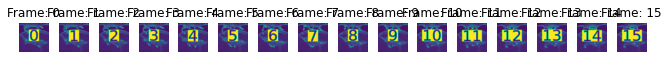

  1%|          | 1/100 [00:00<01:02,  1.59it/s]

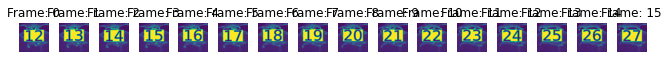

 83%|████████▎ | 83/100 [00:04<00:00, 19.71it/s]


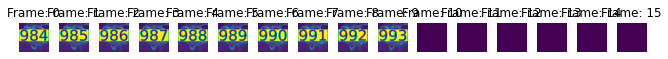

In [53]:
from time import time
start_time = time()
counter = 0
for batch in tqdm(iterator):
    batch = batch[0]["frames"]
    if counter == 0 or counter == 1:
        plot_sequence(batch.cpu().numpy())
        plt.show()
    counter += 1
    #shape =batch[0]["frames"].shape # we don't print now to avoid cluttering the notebook
plot_sequence(batch.cpu().numpy())
plt.show()
end_time = time()
#print(f"Time to iterate over {num_iters} batches: {end_time - start_time}")

In [10]:
total_time = end_time - start_time
time_per_iter = total_time / num_iters
print(f"Total time: {total_time}")
print(f"Time per iteration: {time_per_iter}")

Total time: 7.188077211380005
Time per iteration: 0.07188077211380005


In [2]:
import pandas as pd

In [47]:
# read csv file, old and new and compare.
# load new csv file 
# pred_new = pd.read_csv("/home/jovyan/predicted_vids/61e11a11-ab65-48fb-ae08-3cb80662e5d6_left_heatmap_mhcrnn_pca_singleview_4.25_temporal_4.0.csv", index_col=0, header = [1, 2])
# pred_new = pd.read_csv("/home/jovyan/predicted_vids/mirror-mouse/180609_004_heatmap_mhcrnn_pca_multiview_4.5_pca_singleview_5.0_temporal_4.75.csv", index_col=0, header = [1, 2])
# pred_new = pd.read_csv("/home/jovyan/predicted_vids/dfd8e7df-dc51-4589-b6ca-7baccfeb94b4_left_heatmap_mhcrnn_pca_singleview_4.25_temporal_4.0.csv", index_col=0, header = [1, 2])
pred_new = pd.read_csv("/home/jovyan/predicted_vids/mirror-mouse-new/180609_000_heatmap_mhcrnn_pca_multiview_4.5_pca_singleview_5.0_temporal_4.75.csv", index_col=0, header = [1, 2])

print(pred_new.shape)
pred_new.head()


(30000, 51)


bodyparts  paw1LH_top                         paw2LF_top              \
coords              x           y likelihood           x           y   
0          179.324341  102.575119   0.998630  267.713013  101.411926   
1          179.324341  102.575119   0.998630  267.713013  101.411926   
2          179.324341  102.575119   0.998630  267.713013  101.411926   
3          178.828522  102.620384   0.999485  266.869354  101.392746   
4          178.178665  102.645569   0.995739  265.564758  101.045143   

bodyparts             paw3RF_top                         paw4RH_top  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999692  333.237427   99.280617   0.998140  181.200256  ...   
1           0.999692  333.237427   99.280617   0.998140  181.200256  ...   
2           0.999692  333.237427   99.280617   0.998140  181.200256  ...   
3           0.999814  333.564636  101.255745   0.999910  180.439789  ...   
4           0.999906  337.079773  101.949860   0.999436  180.739777  ...   

bodyparts tailMid_bot    nose_bot                        obsHigh_bot  \
coords     likelihood           x           y likelihood           x   
0            0.999551  376.897675  282.848816   0.998978  196.766846   
1            0.999551  376.897675  282.848816   0.998978  196.766846   
2            0.999551  376.897675  282.848816   0.998978  196.766846   
3            0.998137  376.792145  282.871460   0.998930  198.509293   
4            0.999600  377.098755  282.651611   0.999537  198.253143   

bodyparts                         obsLow_bot                         
coords              y likelihood           x           y likelihood  
0          189.881332   0.015816  388.803040  396.295380   0.999990  
1          189.881332   0.015816  388.803040  396.295380   0.999990  
2          189.881332   0.015816  388.803040  396.295380   0.999990  
3          188.555054   0.004699  388.774078  396.420105   0.999985  
4          188.059113   0.002981  388.777618  396.521606   0.999980  

[5 rows x 51 columns]

In [28]:
# pred_new.shape[0] / 184

In [48]:
pred_old = pd.read_csv("/home/jovyan/predicted_vids/mirror-mouse/180609_000_heatmap_mhcrnn_pca_multiview_4.5_pca_singleview_5.0_temporal_4.75.csv", index_col=0, header = [1, 2])

# pred_old = pd.read_csv("/home/jovyan/grid_artifacts/mirror-mouse/strange-spence-2643/strange-spence-2643-exp0/outputs/2023-01-04/21-52-59/video_preds/180609_004.csv", index_col=0, header = [1, 2])
#pred_old = pd.read_csv("/home/jovyan/grid_artifacts/ibl-pupil/functional-nightingale-5302/functional-nightingale-5302-exp0/outputs/2023-01-26/18-47-00/video_preds/61e11a11-ab65-48fb-ae08-3cb80662e5d6_left.csv", index_col=0, header = [1, 2])
# pred_old = pd.read_csv("/home/jovyan/grid_artifacts/ibl-pupil/functional-nightingale-5302/functional-nightingale-5302-exp0/outputs/2023-01-26/18-47-00/video_preds//dfd8e7df-dc51-4589-b6ca-7baccfeb94b4_left.csv", index_col=0, header = [1, 2])

pred_old.head()
print(pred_old.shape)

(30000, 51)


In [49]:
diff_df = pred_new - pred_old

In [50]:
# check if old and new are identical to the 6th decimal place
import numpy as np
np.allclose(pred_old, pred_new, atol=1e-5)

True

In [51]:
import matplotlib.pyplot as plt

In [111]:
pred_old.columns.levels[0].tolist()[6]

IndexError: list index out of range

In [9]:
# find the index and column where the two dataframes are different
for i in range(pred_old.shape[0]):
    for j in range(pred_old.shape[1]):
        if not np.allclose(pred_old.iloc[i, j], pred_new.iloc[i, j], atol=1e-6):
            print(i, j)
            print(pred_old.iloc[i, j])
            print(pred_new.iloc[i, j])
            print("")

KeyboardInterrupt: 

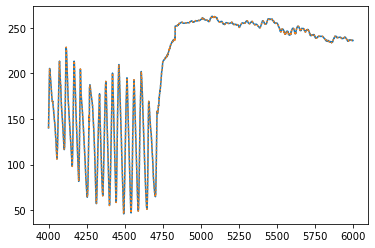

In [52]:
plt.plot(pred_old["paw1LH_top"]["x"][4000:6000])
plt.plot(pred_new["paw1LH_top"]["x"][4000:6000], linestyle='dotted')

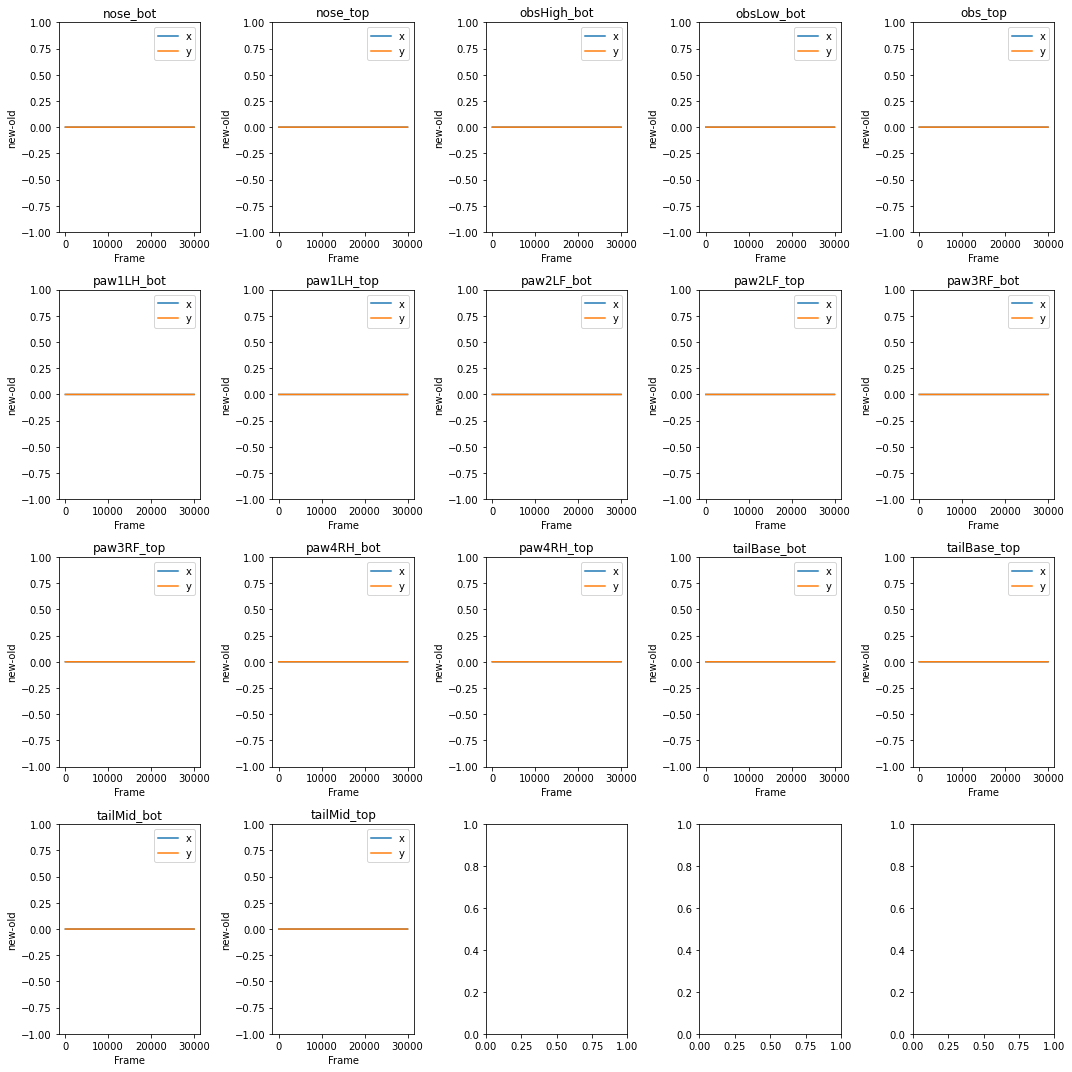

In [54]:
fig, axs = plt.subplots(4, 5, figsize=(15, 15)) # these vals aer for mirror-mouse
ax = axs.flatten()
for i, col in enumerate(diff_df.columns.levels[0]):
    ax[i].plot(diff_df[col]["x"], label="x")
    ax[i].plot(diff_df[col]["y"], label="y")
    ax[i].set_xlabel("Frame")
    ax[i].set_ylabel("new-old")
    ax[i].legend()
    # set y limits between -1 and 1
    ax[i].set_ylim(-1, 1)
    ax[i].set_title(col)
fig.tight_layout()

In [55]:
video_file = "/home/jovyan/litpose-data/mirror-mouse/videos_new/180609_000.mp4"
assert os.path.exists(video_file), f"Video file {video_file} does not exist"


In [116]:
frame_count = count_frames(video_file)
frame_count / 9.


1000.0

In [117]:
frame_count / 60 / 150 # divided by fps and 150

1.0

In [13]:
np.max(np.abs(pred_old - pred_new).round(5))

bodyparts       coords    
pupil_top_r     x             0.00002
                y             0.00002
                likelihood    0.00000
pupil_right_r   x             0.00003
                y             0.00003
                likelihood    0.00000
pupil_bottom_r  x             0.23874
                y             0.12768
                likelihood    0.00411
pupil_left_r    x             0.00002
                y             0.00002
                likelihood    0.00000
dtype: float64

In [14]:
from pandas.testing import assert_frame_equal
assert_frame_equal(pred_old, pred_new)

AssertionError: DataFrame.iloc[:, 6] (column name="('pupil_bottom_r', 'x')") are different

DataFrame.iloc[:, 6] (column name="('pupil_bottom_r', 'x')") values are different (0.01111 %)
[index]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
[left]:  [48.48566055297852, 48.48566055297852, 48.48566055297852, 48.583274841308594, 48.65620803833008, 48.68098449707031, 48.60961532592773, 48.59677505493164, 48.516056060791016, 48.47649765014648, 48.4697494506836, 48.45708465576172, 48.60744094848633, 48.58435821533203, 48.61378860473633, 48.65496444702149, 48.69013595581055, 48.70167541503906, 48.85997772216797, 48.83418655395508, 48.96382141113281, 49.00660705566406, 48.9082260131836, 48.90818786621094, 48.716346740722656, 48.63119888305664, 48.591102600097656, 48.5546989440918, 48.6149787902832, 48.91908645629883, 48.95748519897461, 48.52217864990234, 48.32456588745117, 48.15695190429688, 48.213653564453125, 48.20967483520508, 48.40125274658203, 48.5088005065918, 48.45777893066406, 48.2819938659668, 48.88786697387695, 48.94573593139648, 49.1847038269043, 49.17054748535156, 49.02117156982422, 48.72372817993164, 49.40995407104492, 49.918643951416016, 49.2243766784668, 49.206573486328125, 49.0888900756836, 49.11738586425781, 49.1081657409668, 49.05728530883789, 49.00356674194336, 48.92436218261719, 48.87062454223633, 48.8511848449707, 48.83591079711914, 48.67086410522461, 48.655067443847656, 48.45149993896485, 48.67599868774414, 48.59798812866211, 48.553165435791016, 48.503684997558594, 48.48716354370117, 48.49651336669922, 48.47890853881836, 48.46908950805664, 48.47994613647461, 48.47658157348633, 48.43511962890625, 48.38850784301758, 48.334266662597656, 48.30694961547852, 48.29465866088867, 48.33607864379883, 48.39408874511719, 48.47119903564453, 48.49577713012695, 48.491580963134766, 48.51935958862305, 48.63212585449219, 48.668975830078125, 48.66093063354492, 48.56858444213867, 48.55270385742188, 48.57695388793945, 48.5721549987793, 48.641300201416016, 48.58016586303711, 48.62255096435547, 48.62759780883789, 48.66718673706055, 48.60519027709961, 48.62324523925781, 48.62661361694336, 48.644996643066406, 48.64948272705078, ...]
[right]: [48.485652923583984, 48.485652923583984, 48.485652923583984, 48.58327102661133, 48.656211853027344, 48.68099212646485, 48.60961151123047, 48.59677505493164, 48.51605987548828, 48.47649765014648, 48.46975326538086, 48.45708847045898, 48.60744094848633, 48.58435821533203, 48.6137924194336, 48.654972076416016, 48.690128326416016, 48.70168685913086, 48.85997009277344, 48.83418655395508, 48.96381378173828, 49.006591796875, 48.908233642578125, 48.90818786621094, 48.716346740722656, 48.63119125366211, 48.59109878540039, 48.5546989440918, 48.61497116088867, 48.91908645629883, 48.95747375488281, 48.52217864990234, 48.32456207275391, 48.15695190429688, 48.21364974975586, 48.20967483520508, 48.40125274658203, 48.50880432128906, 48.45777893066406, 48.28199005126953, 48.88786697387695, 48.94572448730469, 49.184696197509766, 49.170555114746094, 49.02117156982422, 48.723724365234375, 49.40995407104492, 49.91865921020508, 49.2243766784668, 49.20656204223633, 49.08889389038086, 49.11738586425781, 49.10816955566406, 49.05728530883789, 49.00355911254883, 48.92436981201172, 48.8706283569336, 48.8511848449707, 48.83591079711914, 48.670860290527344, 48.655067443847656, 48.45149612426758, 48.67599487304688, 48.59798812866211, 48.55316925048828, 48.50367736816406, 48.48716354370117, 48.49651336669922, 48.47890853881836, 48.46909332275391, 48.47994613647461, 48.47658157348633, 48.43511581420898, 48.38851165771485, 48.33425521850586, 48.30694961547852, 48.29467010498047, 48.336082458496094, 48.394081115722656, 48.47119522094727, 48.49577713012695, 48.4915771484375, 48.51936340332031, 48.63212585449219, 48.668975830078125, 48.66093444824219, 48.56858825683594, 48.552711486816406, 48.57695388793945, 48.57215118408203, 48.64129257202149, 48.58015823364258, 48.62255859375, 48.62759780883789, 48.66718673706055, 48.60519027709961, 48.62324142456055, 48.62661361694336, 48.644996643066406, 48.64948272705078, ...]

In [56]:
from lightning_pose.utils.predictions import create_labeled_video
from moviepy.editor import VideoFileClip


In [59]:
video_clip = VideoFileClip(video_file)
# transform df to numpy array
keypoints_arr = np.reshape(pred_new.to_numpy(), [pred_new.shape[0], -1, 3])
xs_arr = keypoints_arr[:, :, 0]
ys_arr = keypoints_arr[:, :, 1]
mask_array = keypoints_arr[:, :, 2] > 0.99
# video generation
create_labeled_video(
    clip=video_clip,
    xs_arr=xs_arr,
    ys_arr=ys_arr,
    dotsize=5,
    fps=50,
    mask_array=mask_array,
    filename="/home/jovyan/single_context_pred_test.mp4",
)


Duration of video [s]: 120, recorded with 250.0 fps!
Moviepy - Building video /home/jovyan/single_context_pred_test.mp4.
Moviepy - Writing video /home/jovyan/single_context_pred_test.mp4



Moviepy - Done !
Moviepy - video ready /home/jovyan/single_context_pred_test.mp4


In [39]:
pred_new.to_numpy()[:, 0::2]

(9000, 6)

In [45]:
pred_new[-4:]

bodyparts pupil_top_r                       pupil_right_r             \
coords              x          y likelihood             x          y   
8996        49.413918  43.008102   0.997702     56.405300  51.545315   
8997        49.461967  42.908688   0.997558     56.705212  51.199047   
8998        49.461967  42.908688   0.997558     56.705212  51.199047   
8999        49.461967  42.908688   0.997558     56.705212  51.199047   

bodyparts            pupil_bottom_r                       pupil_left_r  \
coords    likelihood              x          y likelihood            x   
8996        0.996016      49.084187  60.015690   0.999892    39.716728   
8997        0.999644      48.945850  60.117691   0.999845    39.590496   
8998        0.999644      48.945850  60.117691   0.999845    39.590496   
8999        0.999644      48.945850  60.117691   0.999845    39.590496   

bodyparts                        
coords             y likelihood  
8996       51.562065   0.999594  
8997       51.261848   0.999685  
8998       51.261848   0.999685  
8999       51.261848   0.999685

In [ ]:
create_labeled_video()